# Introduction

You should have a database created from pasing one of the zip files hosted by HHS.



In [1]:
from sqlalchemy import engine_from_config, func
from sqlalchemy.orm import sessionmaker
from hornstone.alchemy import Base
import us
from revaers.models import Data, VaxData
from revaers.parser import parse_csv
from revaers.parser import parse_csvfile
from revaers.parser import parse_vaxfile

import numpy as np
import plotly.io as pio
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import cufflinks as cf

plt.style.use('dark_background')



In [2]:

dburl = 'postgresql+psycopg2://dbadmin@localhost/revaers'
settings = {'sqlalchemy.url': dburl}
engine = engine_from_config(settings)
Base.metadata.create_all(engine)
Session = sessionmaker()
Session.configure(bind=engine)


In [3]:
s = Session()


In [4]:
s.query(Data).count()


108361

In [5]:

def make_data_frame(query):
    return pd.read_sql(query.statement, query.session.bind)


In [6]:

query = s.query(Data, VaxData).join(VaxData)
cvquery = query.filter(VaxData.vax_type == 'COVID19')
# .filter(Data.died == True)
msquery = cvquery.filter(Data.state == 'MS')
dtquery = s.query(Data.recvdate, func.count(Data.vaers_id)).group_by(Data.recvdate).order_by(Data.recvdate)

df = make_data_frame(cvquery)
df[['vax_manu', 'recvdate']].groupby('recvdate')['vax_manu']

In [7]:
df.head()

,vaers_id,recvdate,state,age_yrs,cage_yr,cage_mo,sex,rpt_date,symptom_text,died,...,bad_dates,questionable,vaers_id,vax_type,vax_manu,vax_lot,vax_dose_series,vax_route,vax_site,vax_name
0,916600,2021-01-01,TX,33.0,33.0,,F,None,Right side of epiglottis swelled up and hinder...,False,...,False,False,916600,COVID19,MODERNA,037K20A,1,IM,LA,COVID19 (COVID19 (MODERNA))
1,916601,2021-01-01,CA,73.0,73.0,,F,None,Approximately 30 min post vaccination administ...,False,...,False,False,916601,COVID19,MODERNA,025L20A,1,IM,RA,COVID19 (COVID19 (MODERNA))
2,916602,2021-01-01,WA,23.0,23.0,,F,None,"About 15 minutes after receiving the vaccine, ...",False,...,False,False,916602,COVID19,PFIZER\BIONTECH,EL1284,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH))
3,916603,2021-01-01,WA,58.0,58.0,,F,None,"extreme fatigue, dizziness,. could not lift my...",False,...,False,False,916603,COVID19,MODERNA,unknown,UNK,,,COVID19 (COVID19 (MODERNA))
4,916604,2021-01-01,TX,47.0,47.0,,F,None,"Injection site swelling, redness, warm to the ...",False,...,False,False,916604,COVID19,MODERNA,,1,IM,LA,COVID19 (COVID19 (MODERNA))


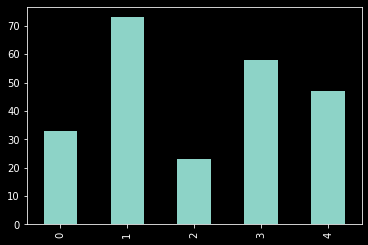

In [8]:
df.head().age_yrs.plot.bar()

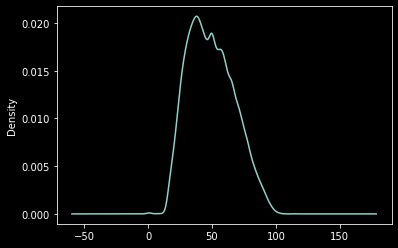

In [48]:
q = s.query(Data, VaxData).join(VaxData)
q = q.filter(VaxData.vax_type == 'COVID19')
#.filter(Data.died == True)
#query = query.filter(Data.state == 'MS')
# q = q.filter(Data.age_yrs < 64).filter(Data.age_yrs > 0)
dq = q.filter(Data.died == True)
df = make_data_frame(q)
df
df.age_yrs.plot.kde()


In [49]:
ev = df[['vaers_id', 'recvdate']].groupby('recvdate').count()
ev.vaers_id.max()

vaers_id    3606
vaers_id    3606
dtype: int64

In [50]:
df.groupby(df.recvdate.dt.isocalendar().week)['vaers_id'].count()

AttributeError: Can only use .dt accessor with datetimelike values

In [51]:
df.groupby('vax_manu').count()


,vaers_id,recvdate,state,age_yrs,cage_yr,cage_mo,sex,rpt_date,symptom_text,died,...,timespan,bad_dates,questionable,vaers_id,vax_type,vax_lot,vax_dose_series,vax_route,vax_site,vax_name
vax_manu,,,,,,,,,,,,,,,,,,,,,
JANSSEN,25098,25098,25098,22135,20482,25098,25098,0,25098,25098,...,176,25098,25098,25098,25098,25098,25098,25098,25098,25098
MODERNA,45075,45075,45075,41707,41721,45075,45075,60,45075,45075,...,1580,45075,45075,45075,45075,45075,45075,45075,45075,45075
PFIZER\BIONTECH,37714,37714,37714,33628,25554,37714,37714,25,37714,37714,...,1334,37714,37714,37714,37714,37714,37714,37714,37714,37714
UNKNOWN MANUFACTURER,142,142,142,132,127,142,142,1,142,142,...,15,142,142,142,142,142,142,142,142,142
